In [256]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [257]:
from enum import Enum

class Action(Enum):
    DEFECT = 0
    COOPERATE = 1

class State(Enum):
    PS_D = 0
    PS_C = 1
    PD_D = 2
    PD_C = 3

In [258]:
# returns the probabilities of the actions  
def boltzmann_exploration(q_table: np.array, state: State, temperature: float) -> np.array:
    exp = np.exp((q_table[state.value, :] - np.max(q_table[state.value, :])) / temperature)
    return exp / np.sum(exp)

In [259]:
def prisoners_dilemma(a_i: Action, a_j: Action) -> tuple[float, float]:
    reward_table = np.array([[(1, 1), (5, 0)], [(0, 5), (3, 3)]])
    return reward_table[a_i.value, a_j.value]

In [260]:
def q_learning(qtable: np.array, state: State, action: Action, 
               reward: float, new_state: State, alpha: float, gamma: float) -> None:
    qtable[state.value, action.value] = (1.0 - alpha) * qtable[state.value, action.value] + \
        alpha * (reward + gamma * np.max(qtable[new_state.value, :]))

In [261]:
class Agent:
    def __init__(self, learning_rate: float, temperature: float, discount_rate: float, 
                 last_action: Action = None, qtable_ps: np.array = None, qtable_pd: np.array = None):
        self.a = learning_rate
        self.t = temperature
        self.g = discount_rate
        self.last_action = Action(random.getrandbits(1)) if last_action == None else last_action
        self.qtable = np.zeros((4, 2))
        
    def get_action_ps(self, state: State) -> Action:
        temp = boltzmann_exploration(self.qtable, state, self.t)
        return np.random.choice([Action.DEFECT, Action.COOPERATE], p=temp)
    
    def get_action_pd(self, state: State) -> Action:
        temp = boltzmann_exploration(self.qtable, state, self.t)
        return np.random.choice([Action.DEFECT, Action.COOPERATE], p=temp)

    def train(self, trajectories, debug=False):
        for trajectory in trajectories:
            q_learning(self.qtable, trajectory[2], trajectory[3], trajectory[5], trajectory[4], self.a, self.g)
            if debug:
                print(trajectory)
                print(self.qtable)
            q_learning(self.qtable, trajectory[0], trajectory[1], 0, trajectory[2], self.a, self.g)
            if debug:
                print(trajectory)
                print(self.qtable)

In [262]:
def sdoo(population: int, rounds: int, episodes: int, learning_rate: float, temperature: float, discount_rate: float):
    recorded_outcomes = {
        (Action.DEFECT, Action.DEFECT): [0 for _ in range(episodes)],
        (Action.DEFECT, Action.COOPERATE): [0 for _ in range(episodes)],
        (Action.COOPERATE, Action.DEFECT): [0 for _ in range(episodes)],
        (Action.COOPERATE, Action.COOPERATE): [0 for _ in range(episodes)],
    }

    agents = [Agent(learning_rate, temperature, discount_rate) for _ in range(population)]
    unpaired = list(range(population))

    # Pair Agents
    pairs: tuple[int, int] = []
    while unpaired:
        i = unpaired.pop(np.random.randint(len(unpaired)))
        j = unpaired.pop(np.random.randint(len(unpaired)))
        pairs.append((i, j))

    
    for episode in range(episodes):

        trajectories = [[] for _ in range(population)]
        for round in range(rounds):

            # Partner Selection
            temp_pairs = []
            for (i, j) in pairs:
                s_i = State.PS_C if agents[j].last_action == Action.COOPERATE else State.PS_D
                s_j = State.PS_C if agents[i].last_action == Action.COOPERATE else State.PS_D
                a_i = agents[i].get_action_ps(s_i)
                a_j = agents[j].get_action_ps(s_j)

                if a_i == Action.DEFECT or a_j == Action.DEFECT:
                    unpaired.append(i)
                    unpaired.append(j)
                else:
                    temp_pairs.append((i, j))

                trajectories[i].append((s_i, a_i))
                trajectories[j].append((s_j, a_j))

            # Pair Agents
            pairs = temp_pairs
            while unpaired:
                i = unpaired.pop(np.random.randint(len(unpaired)))
                j = unpaired.pop(np.random.randint(len(unpaired)))
                pairs.append((i, j))

            # Prisoner's Dilemma
            for (i, j) in pairs:
                s_i = State.PD_C if agents[j].last_action == Action.COOPERATE else State.PD_D
                s_j = State.PD_C if agents[i].last_action == Action.COOPERATE else State.PD_D
                a_i = agents[i].get_action_pd(s_i)
                a_j = agents[j].get_action_pd(s_j)
                r_i, r_j = prisoners_dilemma(a_i, a_j)
                ns_i = State.PS_C if a_j == Action.COOPERATE else State.PS_D
                ns_j = State.PS_C if a_i == Action.COOPERATE else State.PS_D
                recorded_outcomes[(a_i, a_j)][episode] += 1
                agents[i].last_action = a_i
                agents[j].last_action = a_j

                t = trajectories[i][-1]
                trajectories[i][-1] = (t[0], t[1], s_i, a_i, ns_i, r_i)
                t = trajectories[j][-1]
                trajectories[j][-1] = (t[0], t[1], s_j, a_j, ns_j, r_j)

        # print()
        for idx, agent in enumerate(agents):
            agent.train(trajectories[idx]) # debug=(idx == 0)
            print("Agent %i" % (idx))
            print(agent.qtable)
        
        

    # Plot Prisoner's Dilemma Outcomes
    plt.plot(recorded_outcomes[(Action.DEFECT, Action.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes[(Action.DEFECT, Action.COOPERATE)], linewidth=1)
    plt.plot(recorded_outcomes[(Action.COOPERATE, Action.DEFECT)], linewidth=1)
    plt.plot(recorded_outcomes[(Action.COOPERATE, Action.COOPERATE)], linewidth=1)
    
    plt.xlabel('Episode')
    plt.ylabel('Number of Outcomes')
    plt.ylim(0, population * rounds / 2)
    plt.legend(["(D, D)", "(D, C)", "(C, D)", "(C, C)"])

    plt.show()

    ps_strategies = [
        ("Always-Stay", np.array([[0, 1], [0, 1]])),
        ("Out-for-Tat", np.array([[1, 0], [0, 1]])),
        ("Reverse-OFT", np.array([[0, 1], [1, 0]])),
        ("Always-Switch", np.array([[1, 0], [1, 0]])),
    ]
    pd_strategies = [
        ("Always-Cooperate", np.array([[0, 1], [0, 1]])),
        ("Tit-for-Tat", np.array([[1, 0], [0, 1]])),
        ("Reverse-TFT", np.array([[0, 1], [1, 0]])),
        ("Always-Defect", np.array([[1, 0], [1, 0]])),
    ]
    
    num_strategies_ps = [0 for _ in ps_strategies]
    num_strategies_pd = [0 for _ in pd_strategies]

    # print("Episode %i" % (episode))
    # Determine Agent Strategies
    for idx, agent in enumerate(agents):
        strategy_ps = 0
        strategy_ps_angle = 90
        for ps_idx, strategy in enumerate(ps_strategies):
            agent_norm = np.linalg.norm(agent.qtable[0:2, :])
            strategy_norm = np.linalg.norm(strategy[1])
            prod = np.sum(agent.qtable[0:2, :] * strategy[1])
            angle = np.rad2deg(np.arccos(prod / (agent_norm * strategy_norm)))
            if angle < strategy_ps_angle:
                strategy_ps = ps_idx
                strategy_ps_angle = angle

        strategy_pd = 0
        strategy_pd_angle = 90
        for pd_idx, strategy in enumerate(pd_strategies):
            agent_norm = np.linalg.norm(agent.qtable[2:4, :])
            strategy_norm = np.linalg.norm(strategy[1])
            prod = np.sum(agent.qtable[2:4, :] * strategy[1])
            angle = np.rad2deg(np.arccos(prod / (agent_norm * strategy_norm)))
            if angle < strategy_pd_angle:
                strategy_pd = pd_idx
                strategy_pd_angle = angle
        
        num_strategies_ps[strategy_ps] += 1
        num_strategies_pd[strategy_pd] += 1
        print("Agent %i) PS-Strategy: %s (%fdeg), PD-Strategy: %s (%fdeg)" % 
            (idx, ps_strategies[strategy_ps][0], strategy_ps_angle, pd_strategies[strategy_pd][0], strategy_pd_angle))
        print(agent.qtable)

    plt.subplot(211)
    plt.bar([s[0] for s in ps_strategies], num_strategies_ps)
    plt.title('PS-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()

    plt.subplot(212)
    plt.bar([s[0] for s in pd_strategies], num_strategies_pd)
    plt.title('PD-Strategies')
    plt.xlabel('Strategy')
    plt.ylabel('Number of Agents')
    plt.ylim(0, population)
    plt.show()


Agent 0
[[0.05601994 0.11949474]
 [0.06238965 0.1440569 ]
 [0.74684601 0.41881927]
 [0.52361614 0.48675307]]
Agent 1
[[0.01464906 0.21781722]
 [0.10323747 0.08356607]
 [0.54077636 0.87620632]
 [0.6147032  0.01833549]]
Agent 2
[[0.04066553 0.06433522]
 [0.13310771 0.30059303]
 [0.96824606 0.57297633]
 [0.97996222 0.43258202]]
Agent 3
[[0.01002143 0.10088379]
 [0.18018806 0.05768854]
 [1.06016535 0.29744526]
 [0.3477768  0.28549366]]
Agent 4
[[0.11287069 0.12681504]
 [0.09787174 0.03819394]
 [0.99181942 0.12299788]
 [0.58137354 0.00609562]]
Agent 5
[[0.15111827 0.08586544]
 [0.14981539 0.16049031]
 [0.76500668 0.14453304]
 [1.16975576 0.27507045]]
Agent 6
[[0.12480552 0.11154794]
 [0.11840982 0.00731689]
 [0.77059109 0.28531215]
 [0.68840418 0.28099877]]
Agent 7
[[0.10705855 0.02580203]
 [0.10876035 0.18165485]
 [0.49139945 0.41643338]
 [1.02011371 0.29530921]]
Agent 8
[[0.12071491 0.02932205]
 [0.09406341 0.1725261 ]
 [0.15272394 0.30307123]
 [1.05838261 0.41003964]]
Agent 9
[[0.0814183

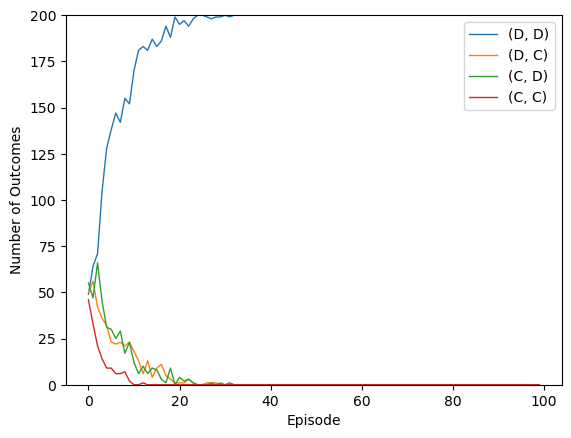

Agent 0) PS-Strategy: Always-Stay (57.721370deg), PD-Strategy: Always-Defect (38.522777deg)
[[36.94779414 37.19519528]
 [ 1.80638021  2.46742538]
 [37.8009197   2.23709617]
 [ 4.41312788  1.51787805]]
Agent 1) PS-Strategy: Always-Stay (57.928505deg), PD-Strategy: Always-Defect (40.986992deg)
[[37.803061   38.11008663]
 [ 1.79752471  2.25655746]
 [38.73797332  4.43357844]
 [ 3.0927722   2.36174979]]
Agent 2) PS-Strategy: Always-Stay (42.571281deg), PD-Strategy: Always-Defect (38.630309deg)
[[ 8.77212176 49.65230811]
 [ 2.36623445  3.01159424]
 [50.1394876   2.22101186]
 [ 5.66993722  0.94659348]]
Agent 3) PS-Strategy: Reverse-OFT (42.148203deg), PD-Strategy: Always-Defect (41.245157deg)
[[ 5.37928136 49.56718203]
 [ 2.81356844  1.39829136]
 [50.05436152  1.48452502]
 [ 3.3734631   2.35832156]]
Agent 4) PS-Strategy: Always-Switch (57.091209deg), PD-Strategy: Always-Defect (38.017392deg)
[[37.19740227 37.04571519]
 [ 3.23627513  1.67527789]
 [37.80414178  1.64986147]
 [ 4.68988022  0.8998

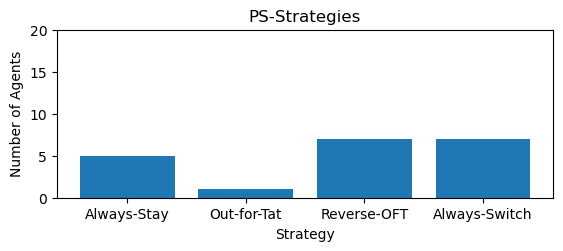

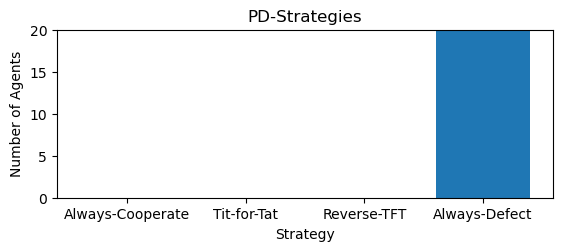

In [263]:
sdoo(20, 20, 100, 0.05, 1, 1)